# How to edit graph state

Human-in-the-loop (HIL) interactions are crucial for [agentic systems](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#human-in-the-loop). Manually updating the graph state a common HIL interaction pattern, allowing the human to edit actions (e.g., what tool is being called or how it is being called).

We can implement this in LangGraph using a [breakpoint](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/): breakpoints allow us to interrupt graph execution before a specific step. At this breakpoint, we can manually update the graph state and then resume from that spot to continue.  

![](./img/edit_graph_state.png)

## Setup

First we need to install the packages required

In [13]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

Next, we need to set API keys for Anthropic (the LLM we will use)

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

ANTHROPIC_API_KEY:  ········


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Simple Usage

Let's look at very basic usage of this.

Below, we do three things:

1) We specify the [breakpoint](https://langchain-ai.github.io/langgraph/concepts/low_level/#breakpoints) using `interrupt_before` a specified step (node).

2) We set up a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer) to save the state of the graph up until this node.

3) We use `.update_state` to update the state of the graph.

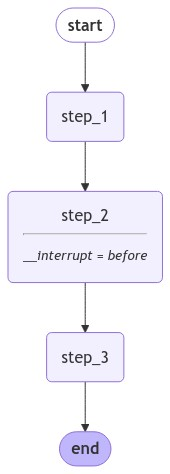

In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str


def step_1(state):
    print("---Step 1---")
    pass


def step_2(state):
    print("---Step 2---")
    pass


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory, interrupt_before=["step_2"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---


Now, we can manually update our graph state. 

This update will overwrite the state channel `input`. 

In [3]:
print("Current state!")
print(graph.get_state(thread).values)

graph.update_state(thread, {"input": "hello universe!"})

print("---\n---\nUpdated state!")
print(graph.get_state(thread).values)

# We can check the next node
graph.get_state(thread).next

Current state!
{'input': 'hello world'}
---
---
Updated state!
{'input': 'hello universe!'}


('step_2',)

In [4]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

---Step 2---
---Step 3---


## Agent

In the context of agents, updating state is useful for things like editing tool calls.
 
To show this, we will build a relatively simple ReAct-style agent that does tool calling. 

We will use Anthropic's models and a fake tool (just for demo purposes).

In [5]:
# Set up the tool
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]


tools = [search]
tool_node = ToolNode(tools)

# Set up the model

model = ChatAnthropic(model="claude-3-5-sonnet-20240620")
model = model.bind_tools(tools)


# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Set up memory
memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable

# We add in `interrupt_before=["action"]`
# This will add a breakpoint before the `action` node is called
app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

## Interacting with the Agent

We can now interact with the agent and see that it stops before calling a tool.


In [6]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "3"}}
inputs = [HumanMessage(content="search for the weather in sf now")]
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

search for the weather in sf now
================================== Ai Message ==================================

[{'text': "Certainly! I can help you search for the current weather in San Francisco. To do this, I'll use the search function to look up the most up-to-date weather information. Let me do that for you right away.", 'type': 'text'}, {'id': 'toolu_01FSkinAVXR1C4D5kecrzAnj', 'input': {'query': 'current weather in San Francisco'}, 'name': 'search', 'type': 'tool_use'}]
Tool Calls:
  search (toolu_01FSkinAVXR1C4D5kecrzAnj)
 Call ID: toolu_01FSkinAVXR1C4D5kecrzAnj
  Args:
    query: current weather in San Francisco


**Edit**

We can now update the state accordingly. Let's modify the tool call to have the query `"current weather in SF"`.

In [7]:
# First, lets get the current state
current_state = app.get_state(thread)

# Let's now get the last message in the state
# This is the one with the tool calls that we want to update
last_message = current_state.values["messages"][-1]

# Let's now update the args for that tool call
last_message.tool_calls[0]["args"] = {"query": "current weather in SF"}

# Let's now call `update_state` to pass in this message in the `messages` key
# This will get treated as any other update to the state
# It will get passed to the reducer function for the `messages` key
# That reducer function will use the ID of the message to update it
# It's important that it has the right ID! Otherwise it would get appended
# as a new message
app.update_state(thread, {"messages": last_message})

{'configurable': {'thread_id': '3',
  'thread_ts': '1ef3e229-4126-628c-8002-2a809f9bb238'}}

Let's now check the current state of the app to make sure it got updated accordingly

In [8]:
current_state = app.get_state(thread).values["messages"][-1].tool_calls
current_state

[{'name': 'search',
  'args': {'query': 'current weather in SF'},
  'id': 'toolu_01FSkinAVXR1C4D5kecrzAnj'}]

**Resume**

We can now call the agent again with no inputs to continue, ie. run the tool as requested. We can see from the logs that it passes in the update args to the tool.

In [9]:
for event in app.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: search

["It's sunny in San Francisco, but you better look out if you're a Gemini \ud83d\ude08."]
================================== Ai Message ==================================

Based on the search results, I can provide you with the current weather information for San Francisco:

The weather in San Francisco is currently sunny. 

It's important to note that the search result also included a playful astrological reference, which isn't directly related to the weather. If you need more specific weather details like temperature, humidity, or forecast, please let me know, and I can perform another search to find that information for you.

Is there anything else you'd like to know about the weather in San Francisco or any other location?
